In [1]:
import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Dense, ReLU, Activation
import matplotlib.pyplot as plt
from tqdm import tqdm

import pickle

%matplotlib inline

In [2]:
import pandas as pd

In [2]:
from tensorflow.keras.datasets import cifar10
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession



config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# CIFAR

In [65]:
alphas = [3., 1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003,0.00001,0.000003,0.000001]

noise_types = ['db', 'jac', 'fob','dbmyfob1_v3','NI','dbfob','nothing','myfob1','dbmyfob1', 'dbmyfob1_v2']

sample_sizes = [50,100,200,1000, 'all']

seeds = [111,222,333,444,555,666,777, 888,999,1111]

In [11]:
data

{'train': [],
 'val': [],
 'acc': [],
 'final_val': 3.661825675307818,
 'final_acc': 0.38533333}

In [6]:
data_type = 'cifar10'

model = 'small'


all_data = []

for training_size in sample_sizes:
    result_arr = []
    for noise in noise_types:
        
        acc_arr = []
        if noise == 'nothing':
            for seed in seeds:
                file_name = f'data/{data_type}_NI_{training_size}_0.0_{model}_{seed}.pk'
                with open(file_name, 'rb') as f:
                    data = pickle.load(f)
                    
                loss, acc = data
                acc_arr.append(acc * 100)
                
                
            
            
        
        # Read best validation
        # Then pick that test result to not overfit the test dataset
        
        else:
        
            for seed in seeds:
                last_epoch_val = []


                for alpha in alphas:
                    file_name = f'data/{data_type}_{noise}_{training_size}_{alpha}_{model}_{seed}.pk'
                    with open(file_name, 'rb') as f:
                        data = pickle.load(f)

                    last_epoch_val.append(data['final_val'])

                alpha_idx = last_epoch_val.index(max(last_epoch_val))

                file_name = f'data/test_{data_type}_{noise}_{training_size}_{alpha}_{model}_{seed}.pk'
                with open(file_name, 'rb') as f:
                    data = pickle.load(f)

                loss, acc = data
                acc_arr.append(acc * 100)
    #         print(acc_arr)
        
        mean = np.mean(acc_arr)
        std = np.std(acc_arr) 
        
        result_text = f'{mean:.2f} ({std:.4f})'
        result_arr.append(result_text)
    all_data.append(result_arr)

pd.DataFrame(all_data, sample_sizes, noise_types)

FileNotFoundError: [Errno 2] No such file or directory: 'data/cifar10_db_50_3e-05_small_111.pk'

In [72]:
data_type = 'cifar10'

model = 'resnet'


all_data = []
all_params = {}

for training_size in sample_sizes:
    result_arr = []
    for noise in noise_types:
        
        acc_arr = []
        if noise == 'nothing':
            for seed in seeds:
                
                file_name = f'data/test_{data_type}_NI_{training_size}_0.0_{model}_{seed}.pk'
                if training_size == 'all':
                    file_name = f'data/{data_type}_NI_{training_size}_0.0_{model}_{seed}.pk'
                try:
                    with open(file_name, 'rb') as f:
                        data = pickle.load(f)
                    try:
                        loss, acc = data
                    except: acc = data['final_acc']
                    acc_arr.append(acc * 100)
                except: pass
#                     print(f'{file_name} not found')
                    
#                 print(data)
                
        
        
        # Read best validation
        # Then pick that test result to not overfit the test dataset
        else:
            param_arr = []
            for seed in seeds:
                last_epoch_val = []


                for alpha in alphas:
                    file_name = f'data/test_{data_type}_{noise}_{training_size}_{alpha}_{model}_{seed}.pk'
                    if training_size == 'all':
                        file_name = f'data/{data_type}_{noise}_{training_size}_{alpha}_{model}_{seed}.pk'
                    try:
                        with open(file_name, 'rb') as f:
                            data = pickle.load(f)
                        try:
                            last_epoch_val.append(data[1] * 100)
                        except: last_epoch_val.append(data['final_acc'] * 100)
                        
                    except: 
                        pass
#                         print(f'{file_name} not found')
                if len(last_epoch_val) == 0: continue
                acc_arr.append(max(last_epoch_val))
                param_arr.append(alphas[last_epoch_val.index(max(last_epoch_val))])
    #         print(acc_arr)

            all_params[f'{noise}_{training_size}'] = param_arr
        
        mean = np.mean(acc_arr)
        std = np.std(acc_arr) 
        
        result_text = f'{mean:.3f} ({std:.2f})'
        result_arr.append(result_text)
        
    all_data.append(result_arr)
    
df = pd.DataFrame(np.array(all_data).T, noise_types, sample_sizes)
# pd.DataFrame(all_params, sample_sizes, noise_types)
# df

In [73]:
refined_df = df.drop(['all'],axis=1).drop(['dbmyfob1_v3', 'dbfob'])

refined_df.index = ['db', 'jac', 'fob','NI','baseline','hsfob','hsfob-db1', 'hsfob-db2']
# refined_df

print(refined_df.to_latex())

\begin{tabular}{lllll}
\toprule
{} &           50   &           100  &           200  &           1000 \\
\midrule
db        &  36.599 (0.87) &  42.156 (1.77) &  49.245 (1.43) &  71.968 (0.86) \\
jac       &  36.063 (1.01) &  40.040 (0.73) &  45.720 (0.65) &  64.128 (1.13) \\
fob       &  36.318 (0.73) &  40.861 (1.35) &  45.674 (0.78) &  64.207 (1.13) \\
NI        &  35.504 (0.64) &  39.302 (1.10) &  45.837 (2.01) &  68.628 (0.70) \\
baseline  &  31.451 (3.02) &  31.992 (4.42) &  39.295 (2.87) &  64.893 (2.18) \\
hsfob     &  35.791 (0.47) &  40.786 (0.61) &  46.016 (0.25) &  64.465 (1.22) \\
hsfob-db1 &  36.191 (0.86) &  41.985 (1.07) &  48.931 (1.44) &  71.852 (1.20) \\
hsfob-db2 &  37.021 (1.40) &  42.089 (1.05) &  47.908 (1.37) &  72.247 (0.67) \\
\bottomrule
\end{tabular}



In [51]:
print(df.iloc[:4].drop(['dbmyfob1_v3', 'dbfob'],axis=1).to_latex())

\begin{tabular}{lllllllll}
\toprule
{} &             db &            jac &            fob &         myfob1 &       dbmyfob1 &    dbmyfob1\_v2 &             NI &        nothing \\
\midrule
50   &  92.273 (0.49) &  91.010 (0.44) &  90.828 (0.36) &  90.881 (0.34) &  92.239 (0.49) &  92.139 (0.34) &  91.283 (0.64) &  90.195 (0.45) \\
100  &  95.010 (0.47) &  94.215 (0.31) &  94.274 (0.40) &  94.106 (0.28) &  95.090 (0.49) &  95.012 (0.41) &  94.180 (0.33) &  93.528 (0.48) \\
200  &  96.725 (0.19) &  96.458 (0.17) &  96.433 (0.21) &  96.479 (0.18) &  96.862 (0.19) &  96.849 (0.20) &  96.475 (0.24) &  96.017 (0.28) \\
1000 &  98.378 (0.10) &  98.258 (0.09) &  98.311 (0.03) &  98.256 (0.09) &  98.389 (0.13) &  98.380 (0.08) &  98.260 (0.08) &  98.015 (0.14) \\
\bottomrule
\end{tabular}



In [34]:
tmp = df.iloc[:4].drop(['dbmyfob1_v3', 'dbfob'],axis=1)
tmp

,db,jac,fob,myfob1,dbmyfob1,dbmyfob1_v2,NI,nothing
50,92.273 (0.49),91.010 (0.44),90.828 (0.36),90.881 (0.34),92.239 (0.49),92.139 (0.34),91.283 (0.64),90.195 (0.45)
100,95.010 (0.47),94.215 (0.31),94.274 (0.40),94.106 (0.28),95.090 (0.49),95.012 (0.41),94.180 (0.33),93.528 (0.48)
200,96.725 (0.19),96.458 (0.17),96.433 (0.21),96.479 (0.18),96.862 (0.19),96.849 (0.20),96.475 (0.24),96.017 (0.28)
1000,98.378 (0.10),98.258 (0.09),98.311 (0.03),98.256 (0.09),98.389 (0.13),98.380 (0.08),98.260 (0.08),98.015 (0.14)


In [35]:
tmp.columns = ['db', 'jac', 'fob', 'hsfob', 'hs-dbfob1', 'hs-dbfob2', 'NI', 'baseline']

In [36]:
print(tmp.to_latex())

\begin{tabular}{lllllllll}
\toprule
{} &             db &            jac &            fob &          hsfob &      hs-dbfob1 &      hs-dbfob2 &             NI &       baseline \\
\midrule
50   &  92.273 (0.49) &  91.010 (0.44) &  90.828 (0.36) &  90.881 (0.34) &  92.239 (0.49) &  92.139 (0.34) &  91.283 (0.64) &  90.195 (0.45) \\
100  &  95.010 (0.47) &  94.215 (0.31) &  94.274 (0.40) &  94.106 (0.28) &  95.090 (0.49) &  95.012 (0.41) &  94.180 (0.33) &  93.528 (0.48) \\
200  &  96.725 (0.19) &  96.458 (0.17) &  96.433 (0.21) &  96.479 (0.18) &  96.862 (0.19) &  96.849 (0.20) &  96.475 (0.24) &  96.017 (0.28) \\
1000 &  98.378 (0.10) &  98.258 (0.09) &  98.311 (0.03) &  98.256 (0.09) &  98.389 (0.13) &  98.380 (0.08) &  98.260 (0.08) &  98.015 (0.14) \\
\bottomrule
\end{tabular}



In [24]:
df = pd.DataFrame(all_data, sample_sizes, noise_types)

In [15]:
all_params

{'db_50': [0.01, 0.1, 0.1, 0.3, 0.03, 0.0003, 0.01, 0.0003, 0.03, 1.0],
 'jac_50': [0.0003, 0.03, 0.0003, 0.0001, 0.0001, 0.03, 3.0, 0.1, 1.0, 3.0],
 'fob_50': [0.0001, 0.1, 0.0001, 0.0003, 0.0001, 1.0, 0.0003, 0.003, 0.1, 0.3],
 'myfob1_50': [0.001, 1.0, 0.001, 3.0, 0.3, 0.3, 0.0003, 0.1, 0.3, 0.003],
 'myfob2_50': [0.001,
  0.0001,
  0.0003,
  0.0001,
  0.0001,
  0.0003,
  0.01,
  0.0003,
  0.0001,
  0.003],
 'NI_50': [0.0003,
  0.003,
  0.003,
  0.1,
  0.001,
  0.0001,
  0.01,
  0.0001,
  0.1,
  0.0001],
 'dbmyfob1_50': [0.1, 0.3, 1.0, 0.001, 0.3, 1.0, 0.1, 0.0003, 0.0001, 0.03],
 'dbmyfob1_v2_50': [0.3,
  0.03,
  1.0,
  0.0001,
  0.0003,
  1.0,
  0.01,
  0.01,
  0.03,
  0.01],
 'dbmyfob1_v3_50': [3.0, 0.1, 0.3, 0.3, 1.0, 1.0, 3.0, 0.3, 0.3, 0.01],
 'db_100': [0.03, 0.01, 3.0, 3.0, 0.1, 3.0, 0.3, 0.1, 0.03, 0.01],
 'jac_100': [0.003, 0.0001, 1.0, 0.1, 0.0001, 3.0, 1.0, 0.001, 0.03, 0.03],
 'fob_100': [0.001, 0.03, 0.003, 0.01, 0.0003, 0.03, 0.1, 0.001, 1.0, 0.0003],
 'myfob1_100': [

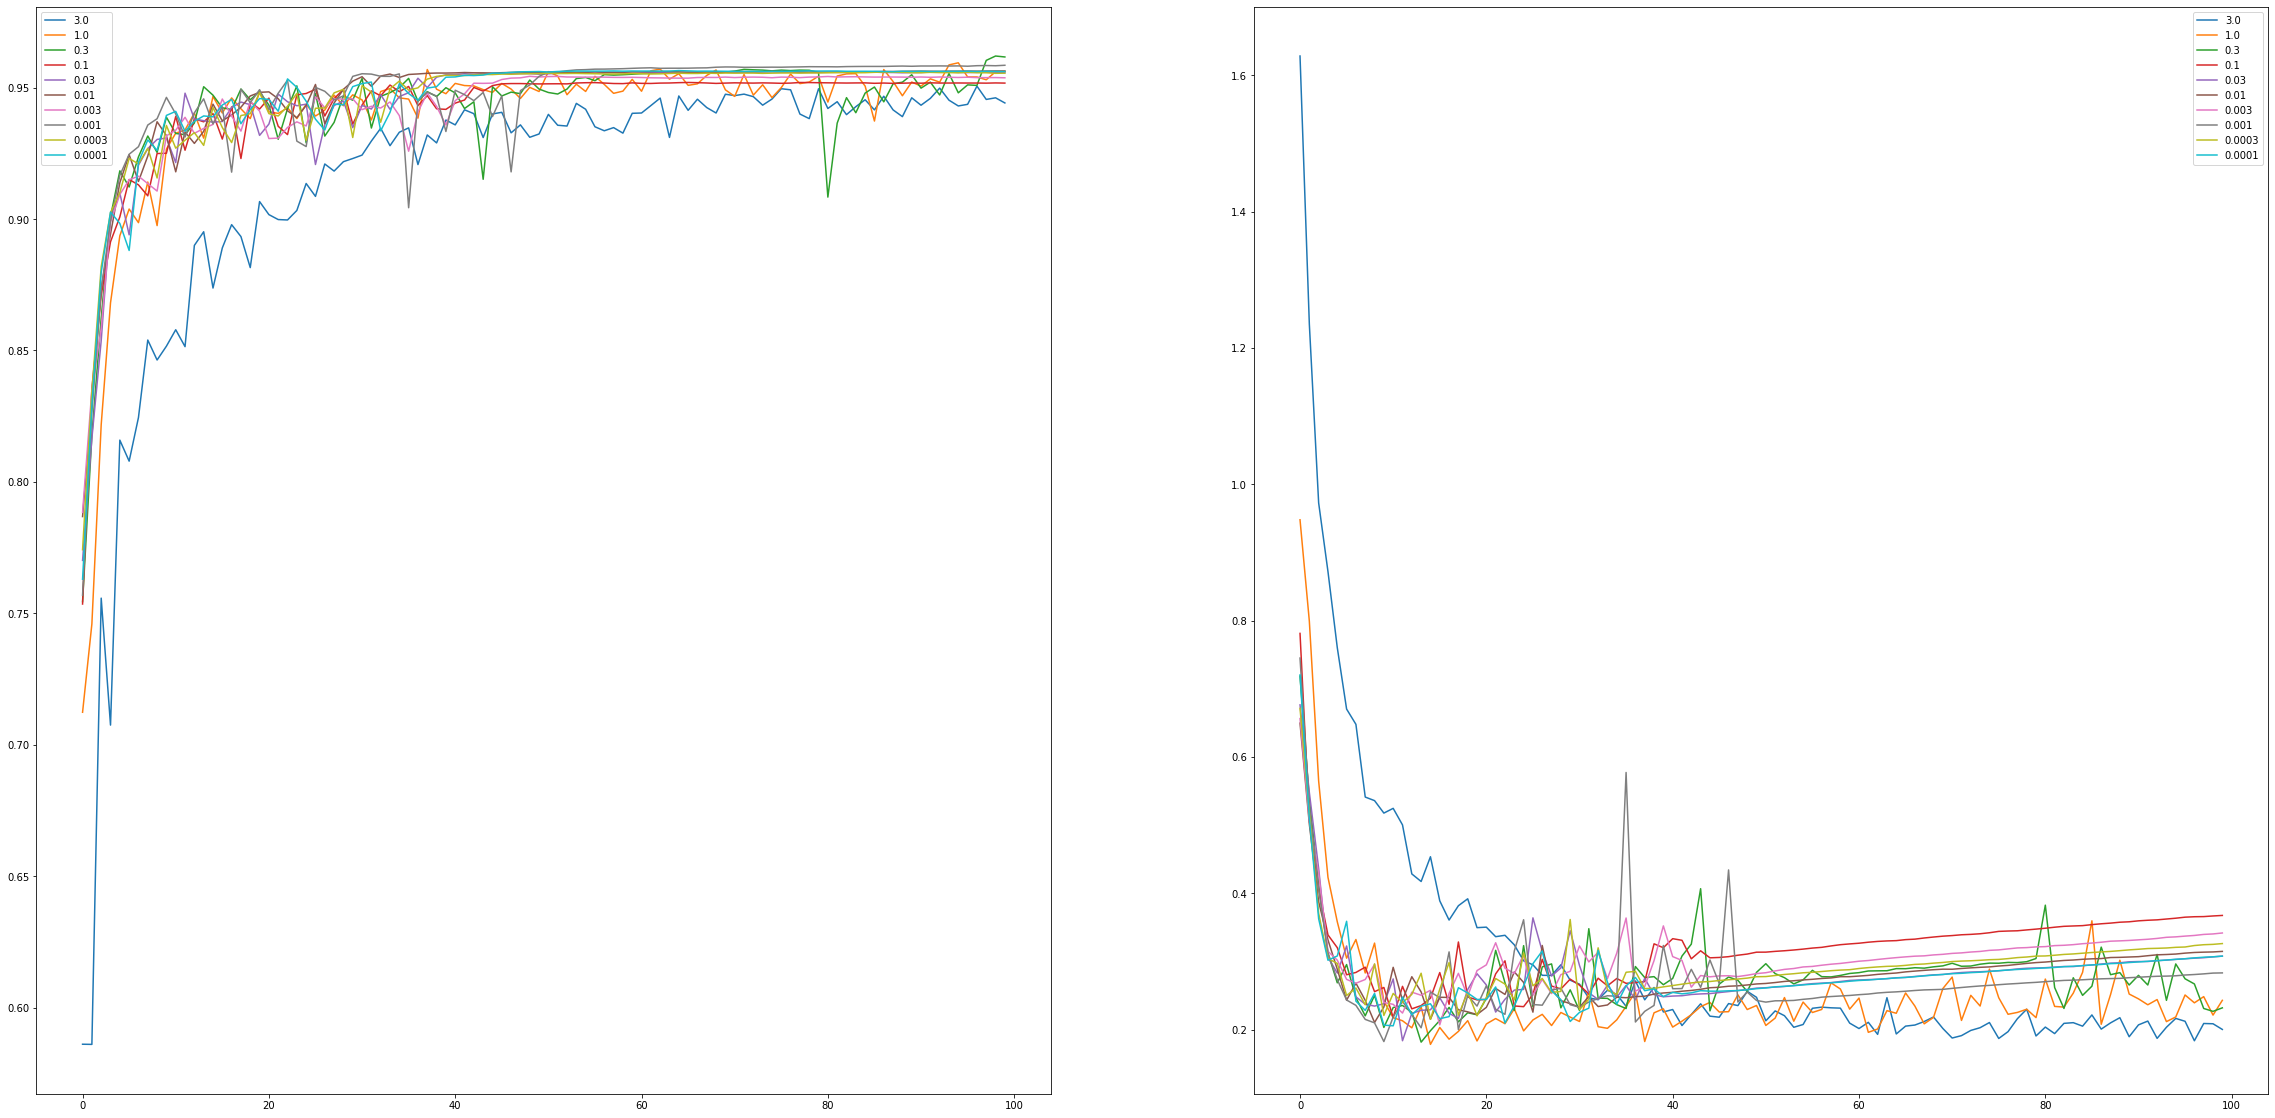

In [101]:
noise = 'NI'
training_size = 200

_, axes = plt.subplots(1,2,figsize=(40,20))
# reg_show = reg_candidate
# for key in reg_show:
#     axes[0].plot(loss_hist_jac[key]['acc'], label=str(key))
#     axes[1].plot(loss_hist_jac[key]['val'], label=str(key))

# axes[0].legend()
# axes[1].legend()

final_acc = {}

for alpha in alphas:
    file_name = f'data/mnist_{noise}_{training_size}_{alpha}_small_333.pk'
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    
    axes[0].plot(data['acc'], label=str(alpha))
    axes[1].plot(data['val'], label=str(alpha))
    final_acc[alpha] = data['final_acc']
    
axes[0].legend()
axes[1].legend()

# MNIST

In [67]:
alphas = [3., 1., 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]

noise_types = ['db', 'jac', 'fob','myfob1','myfob2','NI']

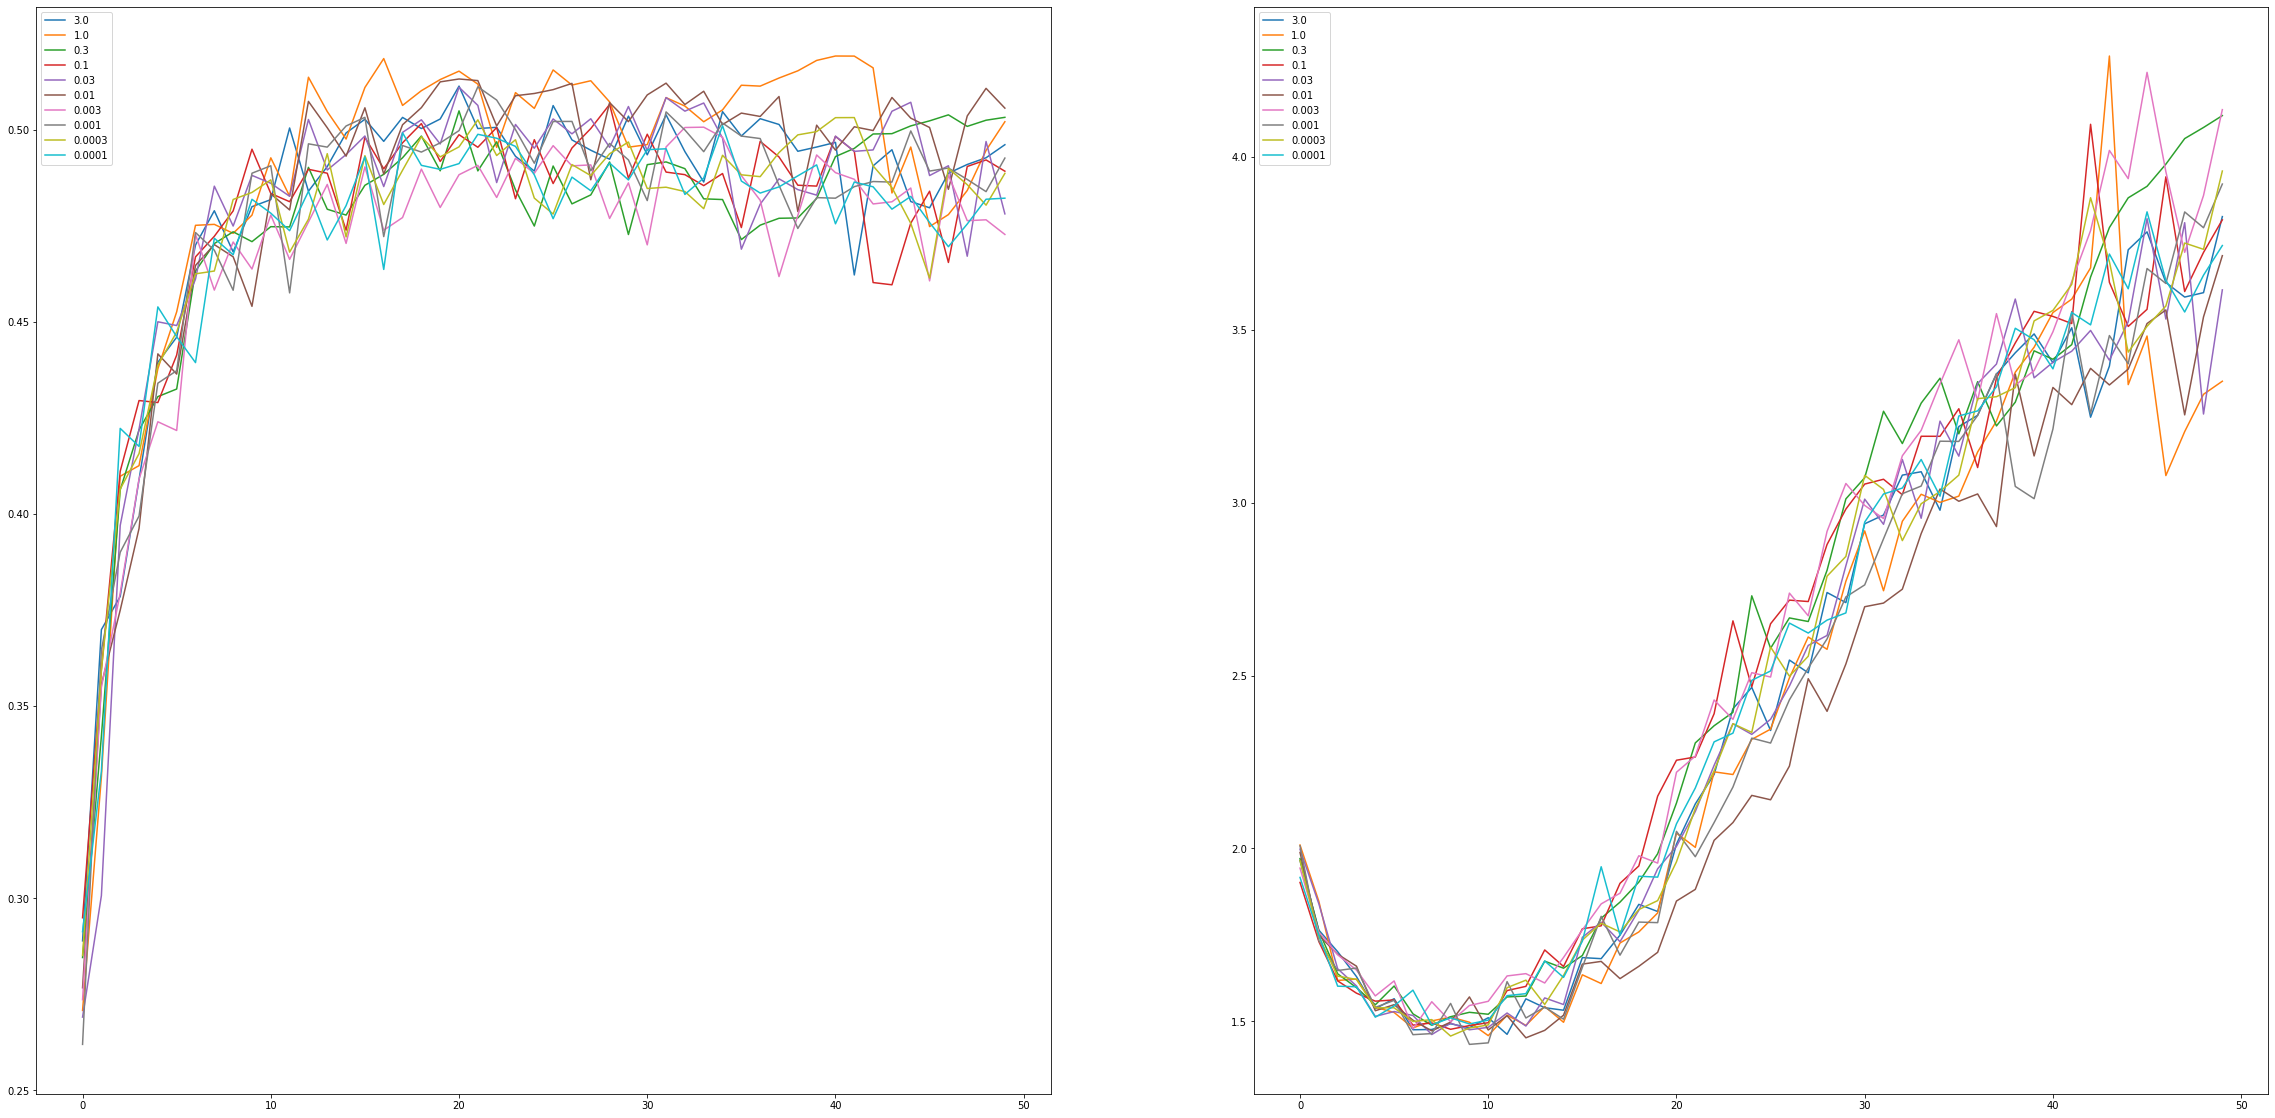

In [70]:
noise = 'myfob1'
training_size = 200

_, axes = plt.subplots(1,2,figsize=(40,20))
# reg_show = reg_candidate
# for key in reg_show:
#     axes[0].plot(loss_hist_jac[key]['acc'], label=str(key))
#     axes[1].plot(loss_hist_jac[key]['val'], label=str(key))

# axes[0].legend()
# axes[1].legend()

final_acc = {}

for alpha in alphas:
    file_name = f'data/cifar10_{noise}_{training_size}_{alpha}_small.pk'
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    
    axes[0].plot(data['acc'], label=str(alpha))
    axes[1].plot(data['val'], label=str(alpha))
    final_acc[alpha] = data['final_acc']
    
axes[0].legend()
axes[1].legend()

In [39]:
p = np.random.uniform(size=[100,1])
p = p / np.sum(p)

In [47]:
H = np.diag(p[:,0]) - p.dot(p.T)

In [49]:
for i in range(100):
    x = np.random.uniform(-10,10,[1,100])
    result = x.dot(H).dot(x.T)
    print(result)

[[28.03582243]]
[[33.85564777]]
[[34.8234195]]
[[29.19567188]]
[[31.29689015]]
[[29.91410891]]
[[36.97316443]]
[[34.74630893]]
[[31.76330806]]
[[39.46444968]]
[[33.85688862]]
[[34.10059876]]
[[31.03848184]]
[[35.4414744]]
[[37.12638021]]
[[31.29282914]]
[[31.50878402]]
[[39.04449305]]
[[31.00259551]]
[[37.24643934]]
[[36.37199283]]
[[33.07507207]]
[[32.82603966]]
[[29.18599558]]
[[31.96855029]]
[[32.68751665]]
[[27.27628479]]
[[33.13914271]]
[[37.35044555]]
[[32.47875074]]
[[25.4671112]]
[[32.11938229]]
[[39.43901457]]
[[35.66969242]]
[[28.4590746]]
[[37.35955629]]
[[36.1773731]]
[[31.33784202]]
[[28.25752642]]
[[35.28151481]]
[[35.78918486]]
[[40.61633946]]
[[34.83765682]]
[[30.80000354]]
[[36.94103838]]
[[35.11917302]]
[[33.44695285]]
[[33.08401746]]
[[30.76332056]]
[[37.43083832]]
[[30.62128517]]
[[36.48681542]]
[[36.08674915]]
[[31.38793393]]
[[32.74739546]]
[[31.94896905]]
[[40.81707664]]
[[37.18449353]]
[[33.39815569]]
[[32.90613347]]
[[36.38478507]]
[[36.59832271]]
[[28.17968174

In [42]:
p

array([[1.81653000e-02],
       [6.66117355e-03],
       [8.78144514e-04],
       [1.48096824e-02],
       [1.04227009e-04],
       [1.89016637e-02],
       [9.07660006e-03],
       [2.10194589e-03],
       [1.74775631e-02],
       [4.31277498e-03],
       [1.49675602e-02],
       [1.68408255e-02],
       [9.71393299e-03],
       [9.99447055e-03],
       [2.01148475e-03],
       [7.90978937e-03],
       [6.99742587e-03],
       [2.17495059e-03],
       [1.50883499e-02],
       [8.55601185e-03],
       [7.70872310e-03],
       [6.60781928e-03],
       [3.48046952e-03],
       [2.23611432e-03],
       [9.87310276e-03],
       [8.24703847e-03],
       [1.66730677e-03],
       [4.25040475e-03],
       [1.73188064e-02],
       [5.45857334e-03],
       [5.99516507e-03],
       [4.56056070e-03],
       [1.95062648e-02],
       [1.13506477e-02],
       [5.40480238e-03],
       [3.92201766e-05],
       [8.66496530e-03],
       [2.02064095e-03],
       [1.57577328e-02],
       [6.62621091e-03],
